Step 1.1: Load Data

In [1]:
from deepdow.benchmarks import OneOverN, Random
from deepdow.callbacks import EarlyStoppingCallback
from deepdow.data import InRAMDataset
from deepdow.data import RigidDataLoader
from deepdow.experiments import Run
from deepdow.losses import MeanReturns, SharpeRatio, MaximumDrawdown, CumulativeReturn
from deepdow.nn import BachelierNet
from deepdow.utils import raw_to_Xy
from deepdow.visualize import generate_metrics_table, generate_weights_table, plot_metrics, plot_weight_heatmap
from pandas_ta import Imports
from sklearn.preprocessing import MinMaxScaler

import pandas as pd
import torch
import yfinance as yf

# CREDIT TO DeepDow library
# This project utilizes DeepDow framework which provides and end-to-end Machine Learning based Portfloio Allocation. 
# Our primary focus is on feature engineering and tuning hyperparameters to show improvement of portfolio allocation using ML model.


2024-02-25 22:00:46.397801: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-25 22:00:46.397844: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-25 22:00:46.398605: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-25 22:00:46.403877: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-25 22:00:47.096782: W tensorflow/compiler/tf2

In [2]:
# DEFINE EXPERIMENT PARAMETER (incl. Hyperparameters) HERE

tickers = ['SPY','BILL']
start = '2023-01-01'
end = '2023-12-31'

lookback, gap, horizon = 10, 1, 5

In [3]:

original = yf.download(tickers, start=start, end=end)
print('original', original.shape)

/opt/ha/capstone/env/lib/python3.9/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[                       0%%                      ]/opt/ha/capstone/env/lib/python3.9/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  2 of 2 completed

original (250, 12)


Step 1.2: Add Features

In [4]:
df = original.swaplevel(0, 1, 1)

scale_min = 0.01
scale_max = 1.00

for ticker in df.columns.levels[0]:
    rsi = df[ticker].ta.rsi()
    rsi = pd.DataFrame(rsi.values, index=rsi.index, columns=['RSI'])
    rsi = pd.DataFrame(MinMaxScaler((scale_min, scale_max)).fit_transform(rsi), index=rsi.index, columns=rsi.columns)
    df[(ticker,'RSI')] = rsi
    
    macd = df[ticker].ta.macd()
    macd = pd.DataFrame(MinMaxScaler((scale_min, scale_max)).fit_transform(macd), index=macd.index, columns=macd.columns)
    for c in macd.columns:
        df[(ticker, c)] = macd[c]

    bbands = df[ticker].ta.bbands()
    bbands = pd.DataFrame(MinMaxScaler((scale_min, scale_max)).fit_transform(bbands), index=bbands.index, columns=bbands.columns)
    for c in bbands.columns:
        df[(ticker, c)] = bbands[c]

    stoch = df[ticker].ta.stoch(append=True)
    stoch = pd.DataFrame(MinMaxScaler((scale_min, scale_max)).fit_transform(stoch), index=stoch.index, columns=stoch.columns)
    for c in stoch.columns:
        df[(ticker, c)] = stoch[c]
    
    obv = df[ticker].ta.obv()
    obv = pd.DataFrame(obv.values, index=obv.index, columns=['OBV'])
    obv = pd.DataFrame(MinMaxScaler((scale_min, scale_max)).fit_transform(obv), index=obv.index, columns=obv.columns)
    df[(ticker,'OBV')] = obv

df = df.dropna(axis=0)
assert isinstance(df, pd.DataFrame)
assert isinstance(df.index, pd.DatetimeIndex)
assert isinstance(df.columns, pd.MultiIndex)

n_timesteps = len(df)
n_channels = len(df.columns.levels[1])
n_assets = len(df.columns.levels[0])

print('n_timesteps\t', n_timesteps)
print('n_assets\t', n_assets)
print('n_channels (features)\t', n_channels)
print('features', df.columns.levels[1])

df.head()

n_timesteps	 217
n_assets	 2
n_channels (features)	 18
features Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'RSI',
       'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'BBL_5_2.0',
       'BBM_5_2.0', 'BBU_5_2.0', 'BBB_5_2.0', 'BBP_5_2.0', 'STOCHk_14_3_3',
       'STOCHd_14_3_3', 'OBV'],
      dtype='object', name='Price')


/tmp/ipykernel_20613/2316058496.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stoch = df[ticker].ta.stoch(append=True)
/tmp/ipykernel_20613/2316058496.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stoch = df[ticker].ta.stoch(append=True)
/tmp/ipykernel_20613/2316058496.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

Ticker           BILL         SPY       BILL         SPY       BILL  \
Price       Adj Close   Adj Close      Close       Close       High   
Date                                                                  
2023-02-21  90.870003  393.115173  90.870003  399.089996  93.474998   
2023-02-22  89.900002  392.573425  89.900002  398.540009  92.339996   
2023-02-23  89.500000  394.661682  89.500000  400.660004  91.014999   
2023-02-24  85.989998  390.445740  85.989998  396.380005  87.559998   
2023-02-27  85.059998  391.775543  85.059998  397.730011  87.250000   

Ticker             SPY       BILL         SPY       BILL         SPY  ...  \
Price             High        Low         Low       Open        Open  ...   
Date                                                                  ...   
2023-02-21  404.160004  90.379997  398.820007  91.000000  403.059998  ...   
2023-02-22  401.130005  89.639999  397.019989  91.550003  399.519989  ...   
2023-02-23  402.200012  86.589996  396.250000  90.879997  401.559998  ...   
2023-02-24  397.250000  84.959999  393.640015  87.550003  395.420013  ...   
2023-02-27  401.290009  85.000000  396.750000  87.250000  399.869995  ...   

Ticker                                                                \
Price      MACDh_12_26_9 MACDs_12_26_9 BBL_5_2.0 BBM_5_2.0 BBU_5_2.0   
Date                                                                   
2023-02-21      0.096914      0.970608  0.224427  0.272358  0.320741   
2023-02-22      0.038159      0.912046  0.182474  0.241874  0.303311   
2023-02-23      0.038672      0.853548  0.190274  0.213076  0.234853   
2023-02-24      0.010000      0.791454  0.175231  0.187349  0.197821   
2023-02-27      0.024931      0.731232  0.202435  0.166745  0.125139   

Ticker                                                                
Price      BBB_5_2.0 BBP_5_2.0 STOCHk_14_3_3 STOCHd_14_3_3       OBV  
Date                                                                  
2023-02-21  0.739559  0.054107      0.276858      0.468391  0.249218  
2023-02-22  0.838735  0.203697      0.150497      0.297535  0.207409  
2023-02-23  0.589765  0.376980      0.097152      0.146002  0.255458  
2023-02-24  0.525087  0.227407      0.133149      0.095697  0.201442  
2023-02-27  0.185054  0.371507      0.169667      0.102408  0.241604  

[5 rows x 36 columns]

Step 2: Prepare X, y

In [5]:
print('- lookback \t', lookback)
print('- gap\t\t', gap)
print('- horizon \t', horizon)
X, timestamps, y, asset_names, indicators = raw_to_Xy(df, lookback=lookback,
                                                      gap=gap, freq="B", horizon=horizon)

print('X', X.shape)
print('y', y.shape)
print('asset_names', asset_names)
print('indicators', indicators)

dataset = InRAMDataset(X, y, timestamps=timestamps, asset_names=asset_names)

- lookback 	 10
- gap		 1
- horizon 	 5
X (208, 18, 10, 2)
y (208, 18, 5, 2)
asset_names ['BILL', 'SPY']
indicators ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'RSI', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'BBL_5_2.0', 'BBM_5_2.0', 'BBU_5_2.0', 'BBB_5_2.0', 'BBP_5_2.0', 'STOCHk_14_3_3', 'STOCHd_14_3_3', 'OBV']


Step 4: Train Model

In [6]:
train_test_ratio = 0.8
n_samples = n_timesteps - lookback - horizon - gap + 1
split_ix = int(n_samples * 0.8)
train_ix = list(range(split_ix))
test_ix = list(range(split_ix + lookback + horizon, n_samples))

train_dataloader = RigidDataLoader(dataset, indices=train_ix, batch_size=32)
test_dataloader = RigidDataLoader(dataset, indices=test_ix, batch_size=32)

In [7]:
max_weight = 0.5
hidden_size = 32
network = BachelierNet(n_channels, n_assets, hidden_size=hidden_size, max_weight=max_weight)
loss = SharpeRatio(returns_channel=0)
loss = CumulativeReturn()
benchmarks = {'1overN': OneOverN()}
metrics = {'drawdown': MaximumDrawdown(),
           'cumreturn': CumulativeReturn()
           }


run = Run(network,
          loss,
          train_dataloader,
          val_dataloaders={'test': test_dataloader},
          optimizer=torch.optim.Adam(network.parameters(), amsgrad=True),
          callbacks=[EarlyStoppingCallback(metric_name='loss',
                                           dataloader_name='test',
                                           patience=15)])

history = run.launch(n_epochs=20)

Epoch 15: 100%|██████████| 6/6 [00:01<00:00,  4.09it/s, loss=0.00187, test_loss=-0.04010]


Training interrupted
Training stopped early because there was no improvement in test_loss for 15 epochs


Reference: The evaluation and visualization code was from DeepDow example.

In [8]:
per_epoch_results = history.metrics.groupby(
    ['dataloader', 'metric', 'model', 'epoch'])['value']

print(per_epoch_results.count())  # double check number of samples each epoch
print(per_epoch_results.mean())  # mean loss per epoch

dataloader  metric  model    epoch
test        loss    network  0        26
                             1        26
                             2        26
                             3        26
                             4        26
                             5        26
                             6        26
                             7        26
                             8        26
                             9        26
                             10       26
                             11       26
                             12       26
                             13       26
                             14       26
                             15       26
Name: value, dtype: int64
dataloader  metric  model    epoch
test        loss    network  0       -0.040099
                             1       -0.040099
                             2       -0.040099
                             3       -0.040099
                             4       -0.040099
             

<Axes: xlabel='epoch'>

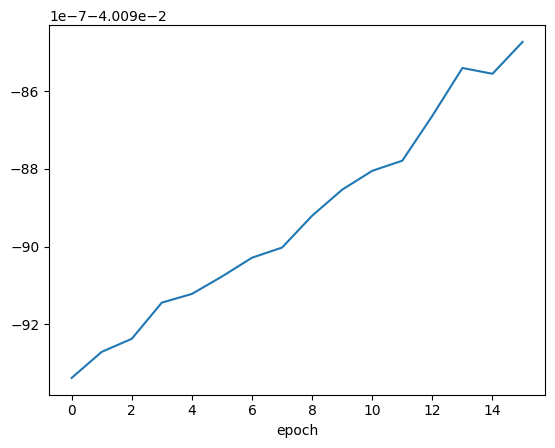

In [9]:
per_epoch_results.mean()['test']['loss']['network'].plot()

array([<Axes: title={'center': 'MaxDD'}, xlabel='timestamp'>,
       <Axes: title={'center': 'Sharpe'}, xlabel='timestamp'>],
      dtype=object)

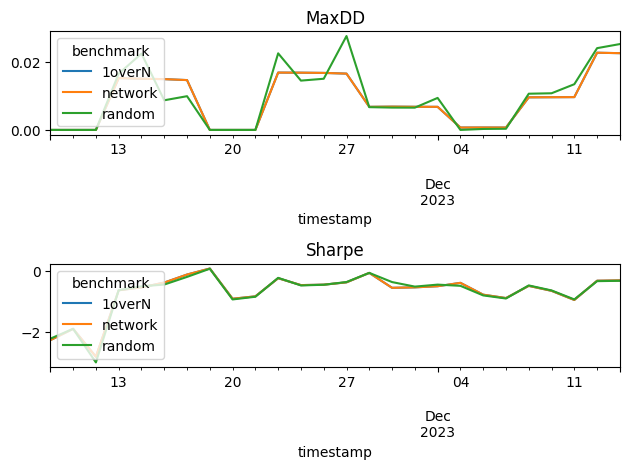

In [10]:

benchmarks = {
    '1overN': OneOverN(),  # each asset has weight 1 / n_assets
    'random': Random(),  # random allocation that is however close 1OverN
    'network': network
}
metrics = {
    'MaxDD': MaximumDrawdown(),
    'Sharpe': SharpeRatio(),
}

metrics_table = generate_metrics_table(benchmarks,
                                       test_dataloader,
                                       metrics)
plot_metrics(metrics_table)

array([<Axes: title={'center': 'MeanReturn'}, xlabel='timestamp'>,
       <Axes: title={'center': 'CumReturn'}, xlabel='timestamp'>],
      dtype=object)

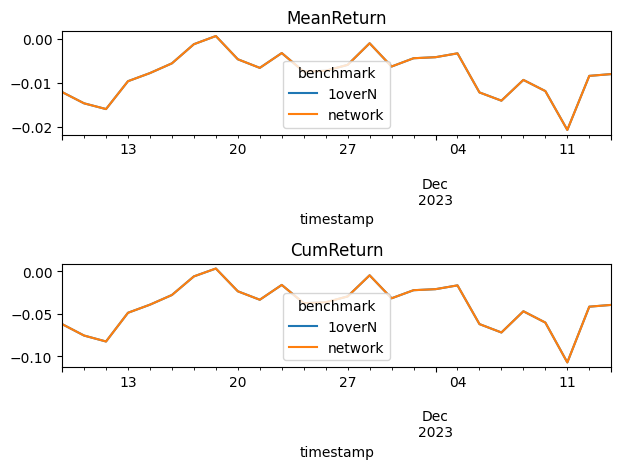

In [11]:
benchmarks = {
    '1overN': OneOverN(),  # each asset has weight 1 / n_assets
    'network': network
}
metrics = {
    'MeanReturn': MeanReturns(),
    'CumReturn': CumulativeReturn()
}

metrics_table = generate_metrics_table(benchmarks,
                                       test_dataloader,
                                       metrics)
plot_metrics(metrics_table)

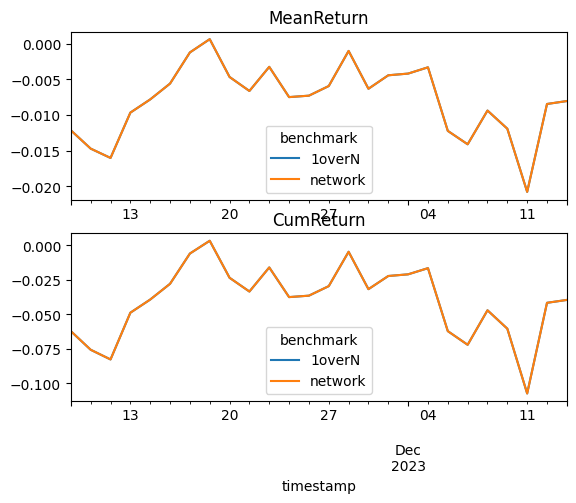

In [12]:
import matplotlib.pyplot as plt

all_metrics = metrics_table["metric"].unique()
n_metrics = len(all_metrics)

_, axs = plt.subplots(n_metrics)

for i, metric_name in enumerate(all_metrics):
    df = pd.pivot_table(
        metrics_table[metrics_table["metric"] == metric_name],
        values="value",
        columns="benchmark",
        index="timestamp",
    ).sort_index()
    df.plot(ax=axs[i])
    axs[i].set_title(metric_name)

plt.show()

<Axes: >

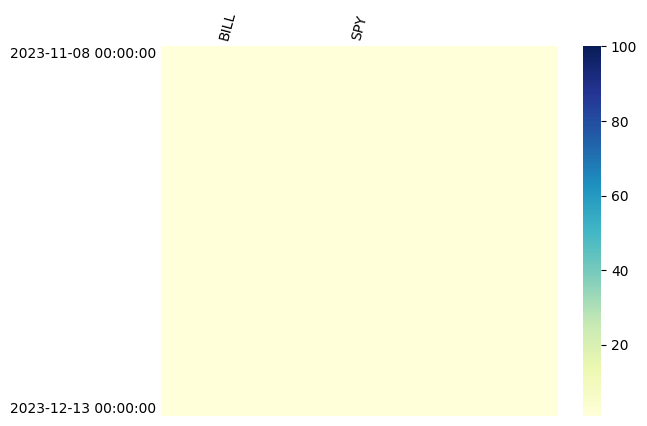

In [13]:

weight_table = generate_weights_table(network, test_dataloader)

plot_weight_heatmap(weight_table,
                    add_sum_column=True,
                    time_format=None,
                    time_skips=25,
                    vmin=100)

In [14]:
weight_table

,BILL,SPY
2023-11-08,0.499932,0.500068
2023-11-09,0.499943,0.500057
2023-11-10,0.499945,0.500055
2023-11-13,0.499940,0.500060
2023-11-14,0.499945,0.500055
2023-11-15,0.499936,0.500064
2023-11-16,0.499993,0.500007
2023-11-17,0.499993,0.500007
2023-11-20,0.499941,0.500059
2023-11-21,0.499944,0.500056
